In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
import numpy as np
import seaborn as sns
from plotting_function import customize_save_and_show_plot
from scipy.stats import linregress

# Step 3: Comparing 90th percentile- and Mean-based MORO
In this notebook, we will compare the different policies identified through the Multi-Objective Robust Optimizations (MORO). To achieve this, we have run all 25 policies under 1,000 different scenarios in `Step3_Simulate_MORO_Policies_Under_Uncertainty.py`. Analyzing these policies across various scenarios will help us assess their performance and robustness.

To maintain consistency and clarity throughout the analysis, we will use a specific color scheme. Green will represent the 90th percentile-based policies, and Blue will represent the mean-based policies. This color coding will help us clearly distinguish between the two types of optimizations and highlight their respective impacts.

# 1. Cleaning and Setting Up
Let us first set a color palette.

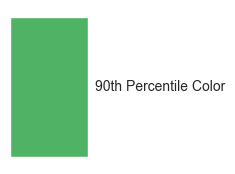

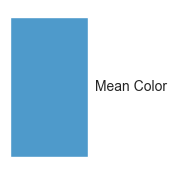

In [2]:
# Get the middle color from Greens and Blues color maps
greens_palette = sns.color_palette("Greens", as_cmap=True)
blues_palette = sns.color_palette("Blues", as_cmap=True)

# Define the middle color index (approximately half of 256)
middle_index = 150

percentile_90_color = greens_palette(middle_index / 256)
mean_color = blues_palette(middle_index / 256)

# Display the colors in a plot for visual reference
for color, label in [(percentile_90_color, '90th Percentile Color'), (mean_color, 'Mean Color')]:
    plt.figure(figsize=(2, 2))
    plt.barh([0], [1], color=[color])
    plt.text(1.1, 0, label, va='center', ha='left')
    plt.xlim(0, 2)
    plt.axis('off')

plt.show()

Let us load the experiments and outcomes created in `Step3_Simulate_MORO_Policies_Under_Uncertainty.py`.

In [3]:
# Load the data
data_dir = os.path.join('data', 'output_data', 'Step3')
experiments_file = os.path.join(data_dir, 'policy_evaluation_experiments.csv')
outcomes_file = os.path.join(data_dir, 'policy_evaluation_outcomes.csv')

experiments = pd.read_csv(experiments_file)
outcomes = pd.read_csv(outcomes_file)   

Our outcomes dataframe already has a policy column containing the type and number for the different policies. However, to effectively label and classify the different outcomes in the plots we will create, we need an additional column. We will now create a 'Type' column that will contain either "Mean" or "90th Percentile" to label the different kinds of policies. This will help with clear and consistent labeling in our visualizations.

In [4]:
# Add a 'Type' column to classify policies
data = outcomes[['Combined Expected Annual Damage', 'Combined Dike Investment Costs', 'Combined Expected Number of Deaths', 'policy']].copy()
data.loc[:, 'Type'] = data['policy'].apply(lambda x: '90th Percentile' if '90th' in x else 'Mean')

# Verify the data
print(data)

       Combined Expected Annual Damage  Combined Dike Investment Costs  \
0                         0.000000e+00                    9.695195e+06   
1                         0.000000e+00                    9.695195e+06   
2                         0.000000e+00                    9.695195e+06   
3                         4.516571e+07                    9.695195e+06   
4                         2.221226e+08                    9.695195e+06   
...                                ...                             ...   
24995                     0.000000e+00                    6.320800e+06   
24996                     0.000000e+00                    6.320800e+06   
24997                     4.067479e+07                    6.320800e+06   
24998                     0.000000e+00                    6.320800e+06   
24999                     0.000000e+00                    6.320800e+06   

       Combined Expected Number of Deaths                     policy  \
0                                0.0000

# 2. Comparing Outcomes Under Both Metrics
We will now compare the mean-based and 90th percentile-based policies. To do this, we have run all policies (both mean and 90th percentile-based) under 1,000 different scenarios. This comprehensive testing will allow us to evaluate each policy under both mean and 90th percentile outcomes.

By creating plots that assess the performance of each policy under the metrics of the other approach, we can gain insights into how well the policies perform under different evaluation criteria. Specifically, we will visualize and analyze the policies' outcomes under mean-based metrics and 90th percentile-based metrics, facilitating a thorough comparison between the two optimization approaches.

This cell below therefore calculates the mean and 90th percentile statistics for each policy grouped by policy type, and stores these statistics along with policy information in separate DataFrames. The resulting DataFrames, mean_df and percentile_df, contain the mean and 90th percentile values for damage, investment, and deaths, respectively, along with the policy and type labels. 

In [5]:
# Create DataFrames for mean and 90th percentile statistics
mean_stats = []
percentile_stats = []

for (policy, policy_type), group in data.groupby(['policy', 'Type']):
    # Exclude 'policy' and 'Type' columns for calculations
    group_data = group.iloc[:, :-2]
    
    # Calculate mean and 90th percentile
    means = group_data.mean()
    percentiles = group_data.quantile(0.9)
    
    # Convert to dictionary to reset the index
    means_dict = means.to_dict()
    percentiles_dict = percentiles.to_dict()
    
    # Add policy and type information
    means_dict['Policy'] = policy
    means_dict['Type'] = policy_type
    mean_stats.append(means_dict)
    
    percentiles_dict['Policy'] = policy
    percentiles_dict['Type'] = policy_type
    percentile_stats.append(percentiles_dict)

# Convert lists of dictionaries to DataFrames
mean_df = pd.DataFrame(mean_stats).reset_index(drop=True)
percentile_df = pd.DataFrame(percentile_stats).reset_index(drop=True)

# Rename the first three columns
mean_df.columns = ['Mean Damage', 'Mean Investment', 'Mean Deaths', 'Policy', 'Type']
percentile_df.columns = ['90th Damage', '90th Investment', '90th Deaths', 'Policy', 'Type']

Now that we have two different DataFrames, in this code we create a function to generate parallel coordinates plots for the mean and 90th percentile outcomes. The function maps colors to each policy type (green for 90th percentile-based and blue for mean-based) and plots the first three columns of the DataFrame (damage, investment, and deaths) using these colors. It sets the plot limits based on the minimum and maximum values of these columns and formats the axes for better readability. This visualization helps compare the performance of different policies under the mean and 90th percentile metrics.

<Figure size 2000x200 with 0 Axes>

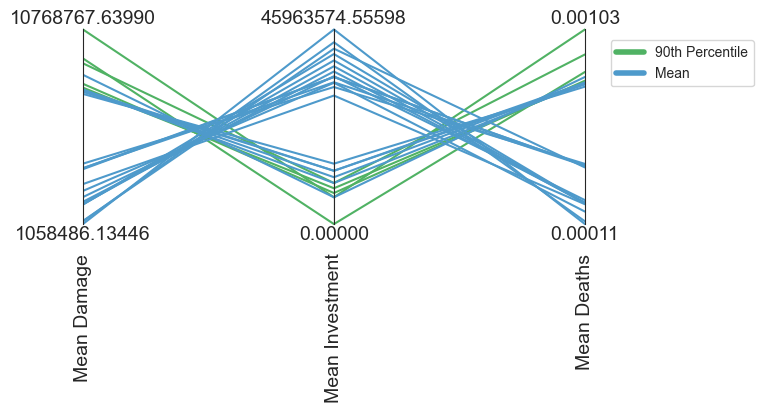

<Figure size 2000x200 with 0 Axes>

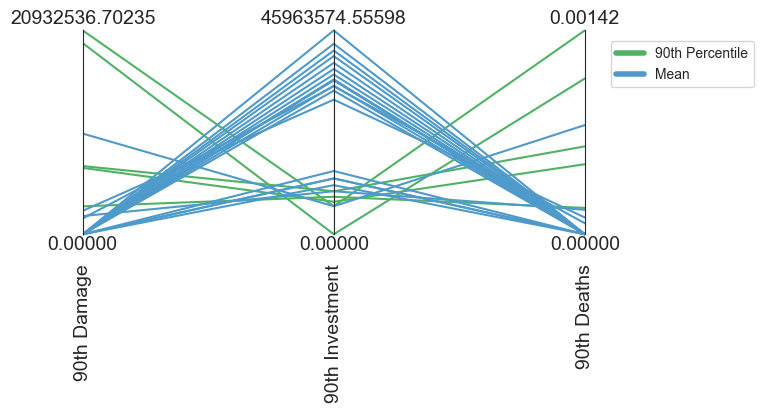

In [6]:
def plot_parallel_coordinates(df, file_suffix):
    # Create a saving directory
    current_dir = os.getcwd()
    dir_path = os.path.join(current_dir, 'data', 'plots', 'Step3')
    os.makedirs(dir_path, exist_ok=True)

    # Define colors for each type
    color_map = {'90th Percentile': percentile_90_color, 'Mean': mean_color}
    colors = df['Type'].map(color_map)

    # Select the first three columns of the DataFrame for plotting
    output_columns = df.columns[:3]
    output = df[output_columns]

    # Creating limits DataFrame with min and max for each of the selected columns
    limits = pd.DataFrame({
        'min': output.min(),
        'max': output.max()
    }).T  # Transpose to have 'min' and 'max' as rows and columns as columns
    
    # Create a formatter dictionary for more decimal places
    formatter = {col: '.5f' for col in output_columns}

    # Create a new figure for plotting
    plt.figure(figsize=(20, 2))
    
    # Initialize ParallelAxes with limits
    axes = parcoords.ParallelAxes(limits, formatter=formatter)
    
    # Plot each line with the appropriate color
    for index, row in df.iterrows():
        axes.plot(row[output_columns], color=colors.loc[index])

    # Adjust the figure to make space for the title and improve layout
    plt.subplots_adjust(top=0.85)
    # plt.title(f'Parallel Coordinates Plot for {file_suffix}', pad=25, fontsize=18)
    
    # Add legend
    handles = [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in color_map.items()]
    plt.legend(handles=handles)
    plt.legend(handles=handles, bbox_to_anchor=(1.7, 0.9), loc='upper right')

    
    # Save and display the plot
    filename = os.path.join(dir_path, f'parallel_coordinates_plot_{file_suffix}.png')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

# Plot the mean and 90th percentile data
plot_parallel_coordinates(mean_df, 'Mean Outcomes')
plot_parallel_coordinates(percentile_df, '90th Percentile Outcomes')

The two parallel coordinates plots provide a comparative analysis of mean-based and 90th percentile-based policies under different outcome metrics: mean outcomes and 90th percentile outcomes. In the first plot, which focuses on mean outcomes, mean-based policies (in blue) generally perform better in terms of average damage and deaths, but not for investment. Conversely, 90th percentile-based policies (in green) exhibit higher average deaths and damages but are associated with lower costs when using the mean metric.

In contrast, the second plot examines 90th percentile outcomes. Here, the green lines representing 90th percentile-based policies generally show lower values in 90th percentile damage and deaths, indicating better robustness under extreme conditions. This robustness comes with lower investment costs, as indicated by the lower 90th percentile investment values. On the other hand, mean-based policies, shown in blue, tend to have higher values for 90th percentile damage and deaths, highlighting their strength in avoiding death and damage in worst-case scenarios, although their costs are extremely high (ranging from 5 to 46 million Euros, compared to a maximum of about 7 million Euros for 90th percentile-based policies).

Overall, the comparison reveals a clear trade-off between cost-efficiency and robustness. Mean-based policies are less cost-effective but perform better on average and under 90th percentile metrics. Conversely, 90th percentile-based policies do not provide strong protection against worst-case deaths and damage scenarios but are significantly cheaper. This insight demonstrates that there is a clear trade-off between deaths and damages versus investment.

This was expected, as our initial exploration revealed that deaths and damages are strongly positively correlated, while investment is negatively correlated with these metrics. 

Therefore, we will now again check correlation for our policy runs under different scenarios to see what we find now.

## 2.1. Correlation Heatmaps 90th percentile- vs mean-based policies
The correlation plots below confirm our earlier observations. The first plot shows a strong positive correlation of 0.98 between deaths and damages and a strong negative correlation of 0.98 between investment and these metrics when considering mean outcomes. Although the correlations for 90th percentile metrics are slightly less pronounced, they remain significant, with moderate correlations of -0.62 and -0.65 between investment and damages/deaths, and a strong correlation of 0.99 between deaths and damages.

These findings emphasize a clear trade-off: higher investment is associated with fewer deaths and damages, while lower investment often leads to more deaths and damages. This is a crucial consideration for policymakers when making decisions. It also stands out that in the 90th percentile the relationship between investment and outcomes is less strong, going from around 95 to around 65 percent. Indicating that investment is less predictive in extreme outcomes, although still strong.

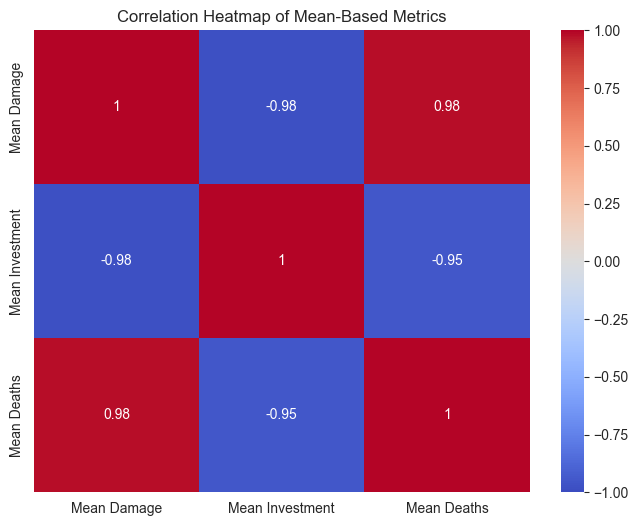

In [7]:
# Calculate the correlation matrix for mean-based metrics
mean_metrics = mean_df[['Mean Damage', 'Mean Investment', 'Mean Deaths']]
correlation_matrix_mean = mean_metrics.corr()

# Plot the correlation heatmap for mean-based metrics
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_mean, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Mean-Based Metrics')
plt.show()

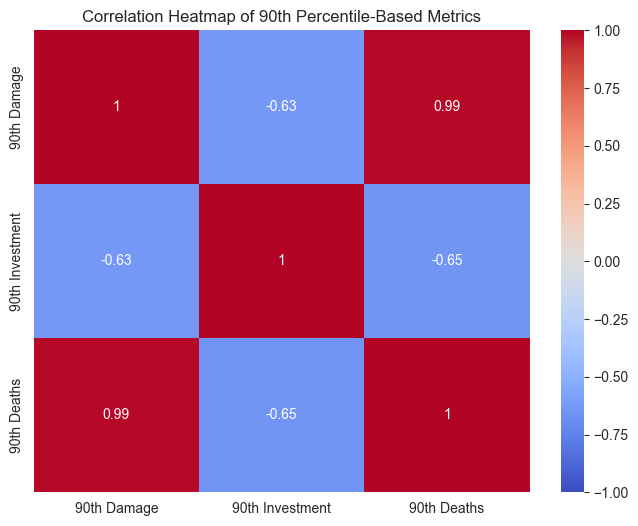

In [8]:
# Calculate the correlation matrix for 90th percentile-based metrics
percentile_metrics = percentile_df[['90th Damage', '90th Investment', '90th Deaths']]
correlation_matrix_percentile = percentile_metrics.corr()

# Plot the correlation heatmap for 90th percentile-based metrics
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_percentile, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of 90th Percentile-Based Metrics')
plt.show()


# 2. Maximum Regret
In the next part we will start calculating the maximum regret metric for every policy in 1000 scenarios.  The maximum regret value refers to the difference in outcome between the best policy and the policy in question for a certain scenario. Afterwards it will calculate the maximum regret that a policy encompasses, thereby looking at the relatively worst outcome for the policy. We will also calculate the mean regret, looking at the average regret that a policy encompasses with a certain metric. 

In [9]:
# Create the 'scenario' column by repeating 0 to 9999 for each policy
num_scenarios = 1000
num_policies = outcomes['policy'].nunique()
outcomes['scenario'] = list(range(num_scenarios)) * num_policies

# Select the outcome columns
outcome_columns = ['Combined Expected Annual Damage', 'Combined Dike Investment Costs', 'Combined Expected Number of Deaths']

# Ensure unique combinations of 'scenario' and 'policy'
outcomes_grouped = outcomes.groupby(['scenario', 'policy']).mean().reset_index()
outcomes_grouped.columns = ['scenario', 'policy', 'A.4 Expected Annual Damage','A.4 Dike Investment Costs', 
                            'A.4 Expected Number of Deaths', 'A.5 Expected Annual Damage', 'A.5 Dike Investment Costs',
                            'A.5 Expected Number of Deaths', 'Damage', 'Investment', 'Deaths']

# Only keep the specified outcome columns and rename DataFrame and columns 
outcomes_filtered = outcomes[['Combined Expected Annual Damage', 'Combined Dike Investment Costs', 'Combined Expected Number of Deaths', 'policy', 'scenario']]
outcomes_filtered.columns = ['Annual Damage', 'Investment Costs', 'Number of Deaths', 'policy', 'scenario']

# Calculate minimum values for each outcome by scenario
min_values_damage = outcomes_filtered.groupby('scenario')['Annual Damage'].min()
min_values_investment = outcomes_filtered.groupby('scenario')['Investment Costs'].min()
min_values_deaths = outcomes_filtered.groupby('scenario')['Number of Deaths'].min()

# Initialize regret lists
regret_damage = []
regret_investment = []
regret_deaths = []

# Get unique policies and scenarios
policy_list = outcomes_filtered['policy'].unique()
scenarios = outcomes_filtered['scenario'].unique()

# Calculate regret for each policy and scenario
for policy in policy_list:
    sub_data = outcomes_filtered[outcomes_filtered['policy'] == policy]
    for scenario in scenarios:
        min_damage = min_values_damage.loc[scenario]
        min_investment = min_values_investment.loc[scenario]
        min_deaths = min_values_deaths.loc[scenario]

        damage_temp = sub_data[sub_data['scenario'] == scenario]['Annual Damage'].values[0] - min_damage
        investment_temp = sub_data[sub_data['scenario'] == scenario]['Investment Costs'].values[0] - min_investment
        deaths_temp = sub_data[sub_data['scenario'] == scenario]['Number of Deaths'].values[0] - min_deaths

        regret_damage.append(damage_temp)
        regret_investment.append(investment_temp)
        regret_deaths.append(deaths_temp)

# Make a copy of outcomes_filtered to avoid SettingWithCopyWarning
outcomes_filtered_copy = outcomes_filtered.copy()

# Add regret values to DataFrame using .loc
outcomes_filtered_copy.loc[:, 'Regret Damage'] = regret_damage
outcomes_filtered_copy.loc[:, 'Regret Investment'] = regret_investment
outcomes_filtered_copy.loc[:, 'Regret Deaths'] = regret_deaths

# Group by policy and find maximum regret
max_regret = outcomes_filtered_copy.groupby('policy')[['Regret Damage', 'Regret Investment', 'Regret Deaths']].max()

# calculate the mean regret
mean_regret = outcomes_filtered_copy.groupby('policy')[['Regret Damage', 'Regret Investment', 'Regret Deaths']].mean()
mean_regret.head

<bound method NDFrame.head of                            Regret Damage  Regret Investment  Regret Deaths
policy                                                                    
90th Percentile Policy 01   8.224830e+06       9.695195e+06       0.000825
90th Percentile Policy 02   7.010723e+06       8.453408e+06       0.000695
90th Percentile Policy 03   7.202604e+06       7.332080e+06       0.000700
90th Percentile Policy 04   9.913473e+06       6.320800e+06       0.000943
90th Percentile Policy 05   8.468607e+06       0.000000e+00       0.000742
Mean Policy 01              2.031913e+05       4.596357e+07       0.000021
Mean Policy 02              3.316793e+05       4.293798e+07       0.000034
Mean Policy 03              3.595524e+05       4.142030e+07       0.000290
Mean Policy 04              1.173344e+06       4.016469e+07       0.000119
Mean Policy 05              1.185065e+06       3.864700e+07       0.000120
Mean Policy 06              1.210200e+06       3.727343e+07       0.00

Now that we have made the dataframe containing the maximum regret per policy per metric it is time to visualize it in a parallel coordinate plot 

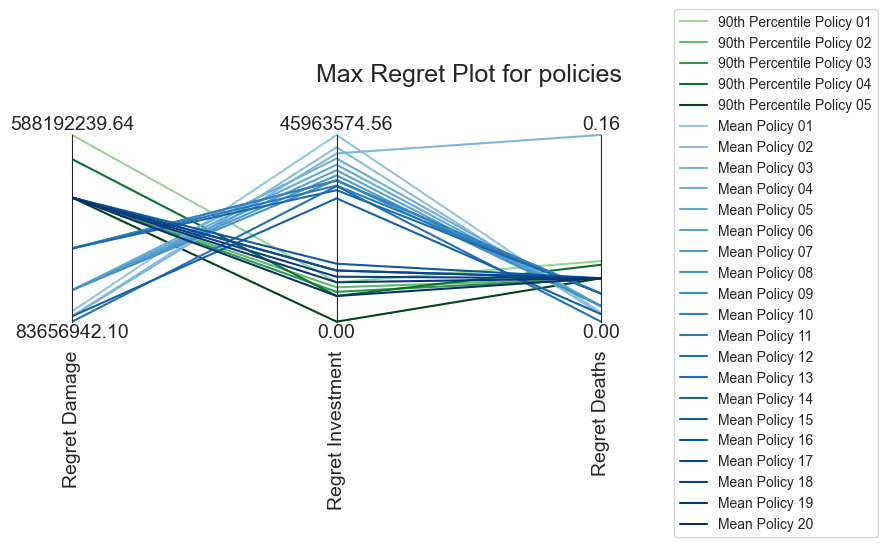

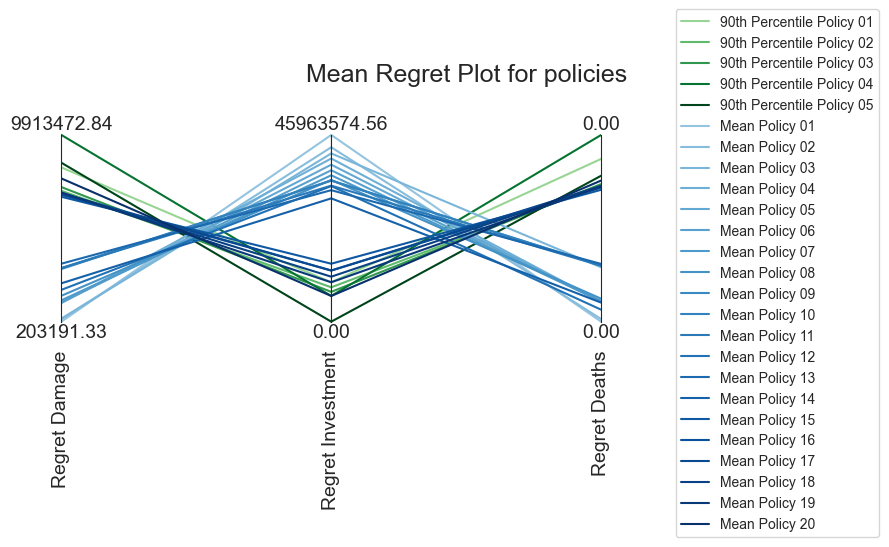

In [10]:
# Function to plot parallel coordinates with two color scales
def plot_parallel_coordinates(df, title):
    # Create a saving directory
    current_dir = os.getcwd()
    dir = os.path.join(current_dir, 'data', 'plots', 'Step3')
    os.makedirs(dir, exist_ok=True)  # Ensure the directory exists

    # Select the columns to plot
    output = df.iloc[:, -3:]  # Select last three columns
    column_names = output.columns.tolist()  # Extract column names

    # Creating limits DataFrame with min and max for each of the columns
    limits = pd.DataFrame({
        'min': output.min(),
        'max': output.max()
    }).T  # Transpose to have 'min' and 'max' as rows and columns as columns

    # Create a new figure for plotting
    # fig, ax = plt.subplots(figsize=(14, 6))
    
    # Initialize ParallelAxes with limits
    axes = parcoords.ParallelAxes(limits)

    # Plot each policy with a unique color based on the policy type
    colors_green = plt.cm.Greens(np.linspace(0.4, 1, len([policy for policy in df.index if policy.startswith('90')])))
    colors_blue = plt.cm.Blues(np.linspace(0.4, 1, len([policy for policy in df.index if policy.startswith('Mean')])))

    green_idx = 0
    blue_idx = 0
    
    for policy in df.index:
        if policy.startswith('90'):
            color = colors_green[green_idx]
            green_idx += 1
        elif policy.startswith('Mean'):
            color = colors_blue[blue_idx]
            blue_idx += 1
        else:
            color = 'gray'  # Fallback color if policy name doesn't match expected patterns
        axes.plot(df.loc[policy].to_frame().T, color=color, label=policy)

    # Adjust the figure to make space for the title and improve layout
    plt.subplots_adjust(top=0.85)
    plt.title(title, pad=25, fontsize=18)

    # Add legend
    plt.legend(df.index, loc='center left', bbox_to_anchor=(1.25, 0.3))

    # Save and display the plot
    filename = os.path.join(dir, title)
    plt.savefig(filename, bbox_inches='tight')
        
    plt.show()

# Example usage
plot_parallel_coordinates(max_regret, 'Max Regret Plot for policies')
plot_parallel_coordinates(mean_regret, 'Mean Regret Plot for policies')

#### Lets look at the similarities between both plots first.
We see a clear divide between the policies that behave well in the cost department and have a low investment, and the policies that do well in the deaths and damage department. Furthermore we do see that some of the policies with a lower investment can perform better in the deaths and damages department than others, this is especially the case for the 90th percentile policies. 
#### Some differences
In the mean regret, we see that the difference between death regret is not very large and amounts at least two digits behind the comma per year. In the case of the maximum regret, this number  lies much higher with a maximum value of 0.16. Which is an outlier in comparison to the rest of the policies. 


### Heatmaps of the regret metrics
In the following code we normalize the regret metrics and create heatplots, to visualize what policy performs in what way. The higher the value the more regret is present in one category. 

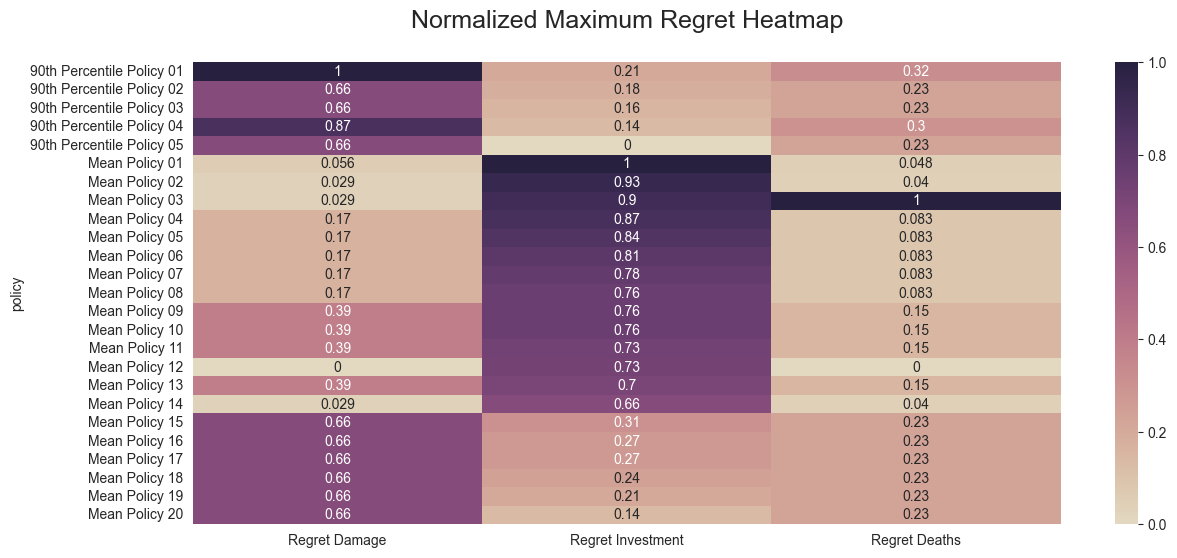

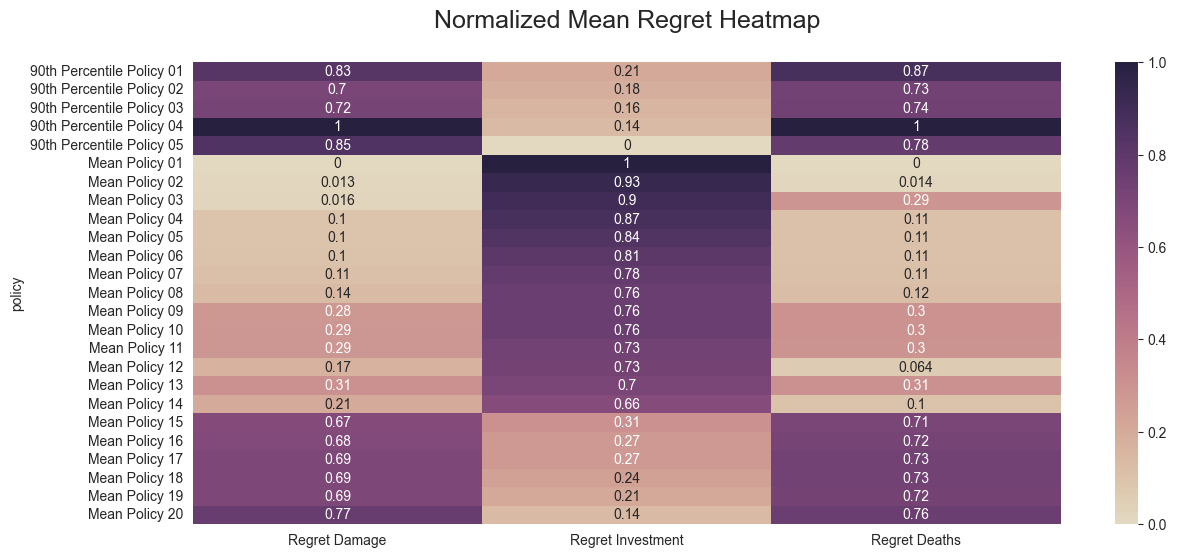

In [11]:
# Normalize the maximum regret values between 0 and 1
mean_regret_normalized =  (mean_regret - mean_regret.min()) / (mean_regret.max() - mean_regret.min())
max_regret_normalized = (max_regret - max_regret.min()) / (max_regret.max() - max_regret.min())
cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

# Function to plot heatmap of normalized maximum regret
def plot_regret_heatmap(max_regret_normalized, title):
    # Create a saving directory
    current_dir = os.getcwd()
    dir_path = os.path.join(current_dir, 'data', 'plots', 'Step3')
    os.makedirs(dir_path, exist_ok=True)

    # Create a heatmap
    plt.figure(figsize=(14, 6))
    sns.heatmap(max_regret_normalized, cmap=cmap, annot=True)

    # Adjust the figure to make space for the title and improve layout
    plt.title(title, pad=25, fontsize=18)

    # Save and display the plot
    filename = os.path.join(dir_path, f'{title}.png')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

# Example usage
plot_regret_heatmap(max_regret_normalized,'Normalized Maximum Regret Heatmap')
plot_regret_heatmap(mean_regret_normalized,'Normalized Mean Regret Heatmap')

### Sorting based on the total regret metrics
The initialized heatmaps lack a specified order, in the following piece of code we will add the total regret score, which weighs each column equally and sort the heatmap based on this metric. For communication purposes and for better understanding of trends within the policy. 

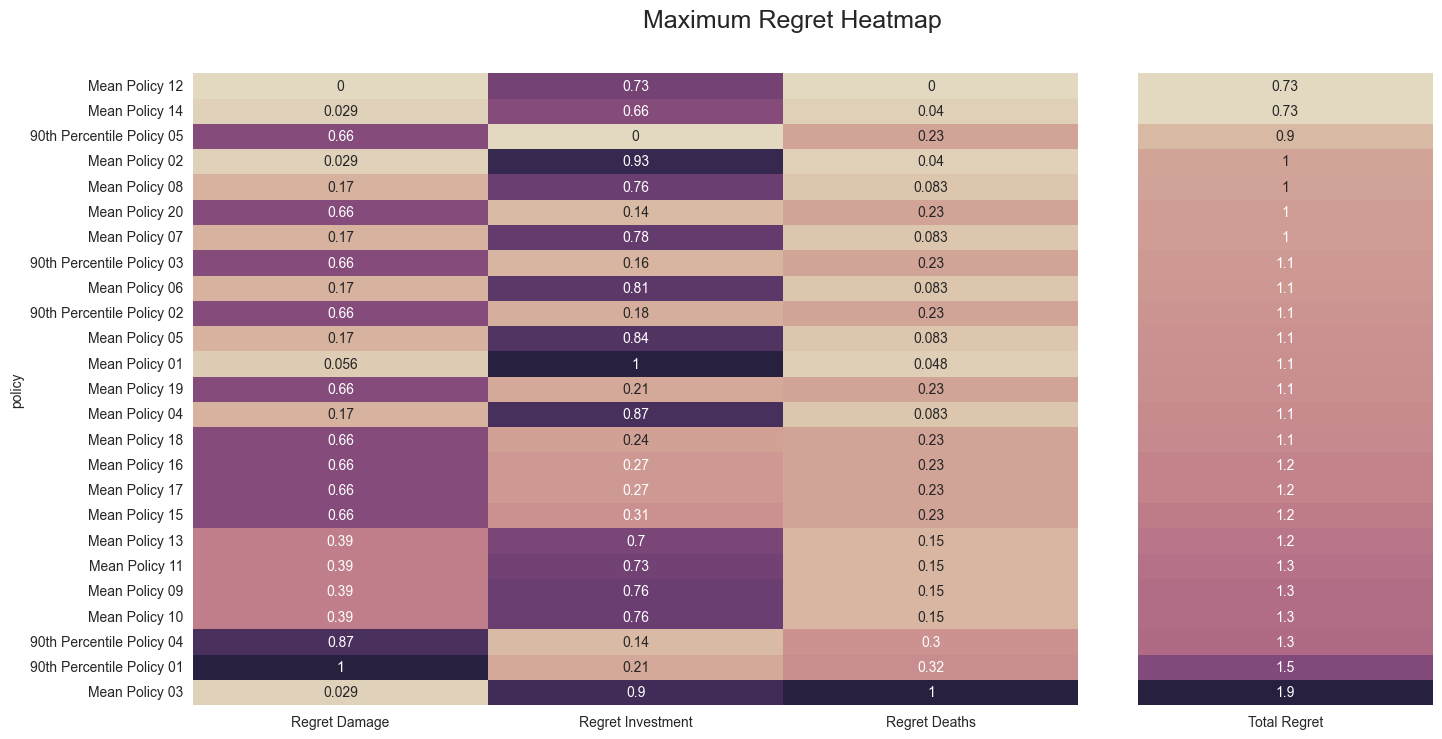

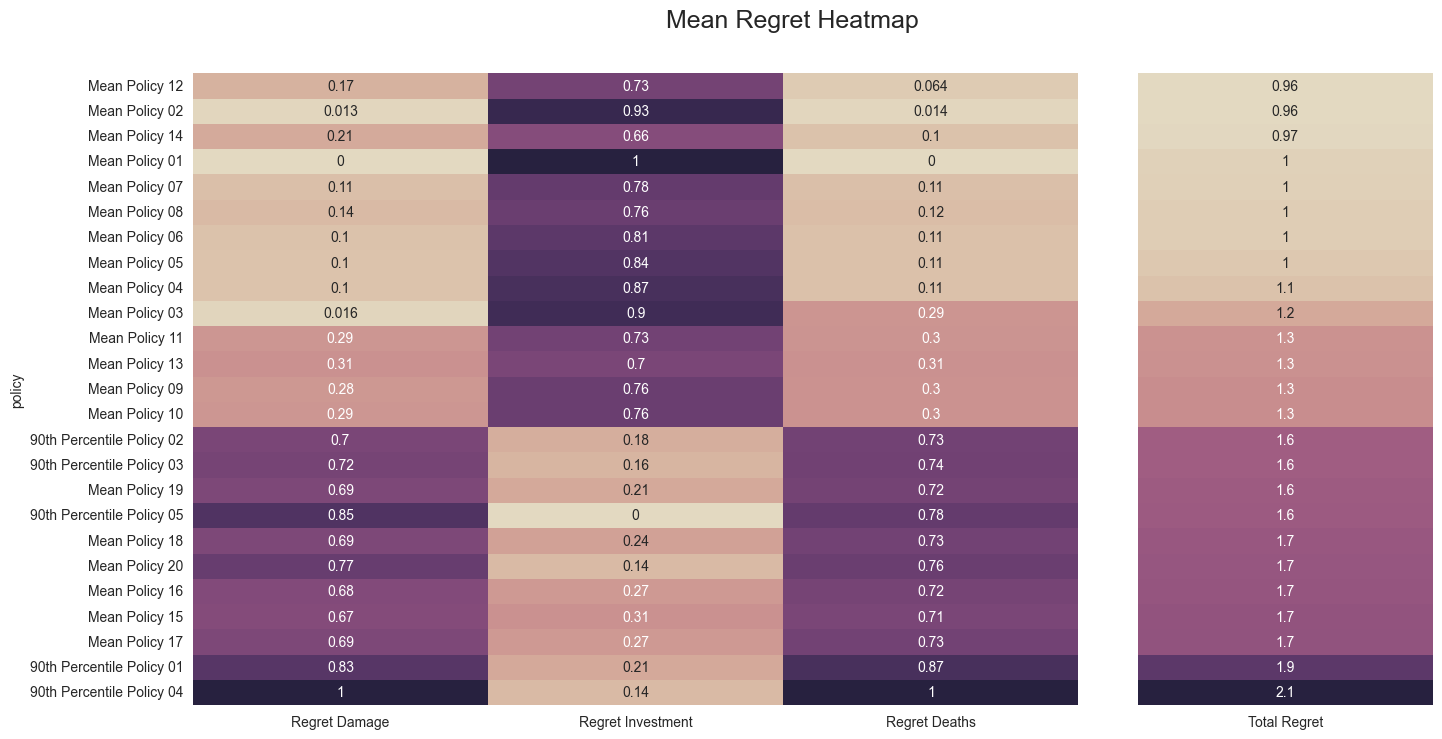

In [12]:
# Calculate aggregate regret score
max_regret_normalized['Total Regret'] = max_regret_normalized.sum(axis=1)
mean_regret_normalized['Total Regret'] = mean_regret_normalized.sum(axis=1)

# Rank policies based on total regret score
max_regret_normalized = max_regret_normalized.sort_values(by='Total Regret')
mean_regret_normalized = mean_regret_normalized.sort_values(by='Total Regret')

# Function to plot heatmap of normalized maximum regret
# def plot_regret_heatmap(df, title):
#     # Create a saving directory
#     current_dir = os.getcwd()
#     dir_path = os.path.join(current_dir, 'data', 'plots', 'Step3')
#     os.makedirs(dir_path, exist_ok=True)  # Ensure the directory exists
# 
#     # Create heatmap
#     plt.figure(figsize=(12, 8))
#     sns.heatmap(df.iloc[:, :], cmap='viridis', annot=True)
#     plt.title(title, pad=20, fontsize=15)
#     
#     # Save and display the plot
#     filename = os.path.join(dir_path, title)
#     plt.savefig(filename, bbox_inches='tight')
#     plt.show()

def plot_regret_heatmap_total(df, title):
    # Create a saving directory
    current_dir = os.getcwd()
    dir_path = os.path.join(current_dir, 'data', 'plots', 'Step3')
    os.makedirs(dir_path, exist_ok=True)  # Ensure the directory exists

    # Set up the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [3, 1]})
    
    # Plot the first three columns with the first colormap
    sns.heatmap(df.iloc[:, :3], cmap=cmap, annot=True, ax=ax1, cbar=False)
    # ax1.set_title('Individual regret', pad=20, fontsize=15)

    # Plot the fourth column with a different colormap
    sns.heatmap(df.iloc[:, 3:4], cmap=cmap, annot=True, ax=ax2, yticklabels=False, cbar=False)
    # ax2.set_title('Total regret', pad=20, fontsize=15)
    ax2.set_ylabel('')
    
    # Adjust the overall title and layout
    fig.suptitle(title, fontsize=18)
    plt.subplots_adjust(top=0.9, wspace=0.1)

    # Save and display the plot
    filename = os.path.join(dir_path, f'{title}.png')
    plt.savefig(filename , bbox_inches='tight')
    plt.show()

plot_regret_heatmap_total(max_regret_normalized, 'Maximum Regret Heatmap')
plot_regret_heatmap_total(mean_regret_normalized, 'Mean Regret Heatmap')

### Creating the policy heatmaps
In the next part of code we retrieve the dataframes created in step 2 and create heatmaps that follow the total mean regret order that was established in step 3 for an organised overview of where policies differ. 

In [13]:
current_directory = os.getcwd()
file = os.path.join(current_directory, 'data', 'output_data', 'Step2','Interpretation_policy_preorder.csv' )
file_total = os.path.join(current_directory, 'data', 'output_data', 'Step2','Total_Policy_Preorder.csv' )
interpretation_policy_preorder = pd.read_csv(file)
total_policy_preorder = pd.read_csv(file_total)
interpretation_policy_preorder.set_index('Type', inplace=True)
total_policy_preorder.set_index('Type', inplace=True)
interpretation_policy_preorder.index.name = 'policy'
total_policy_preorder.index.name = 'policy'

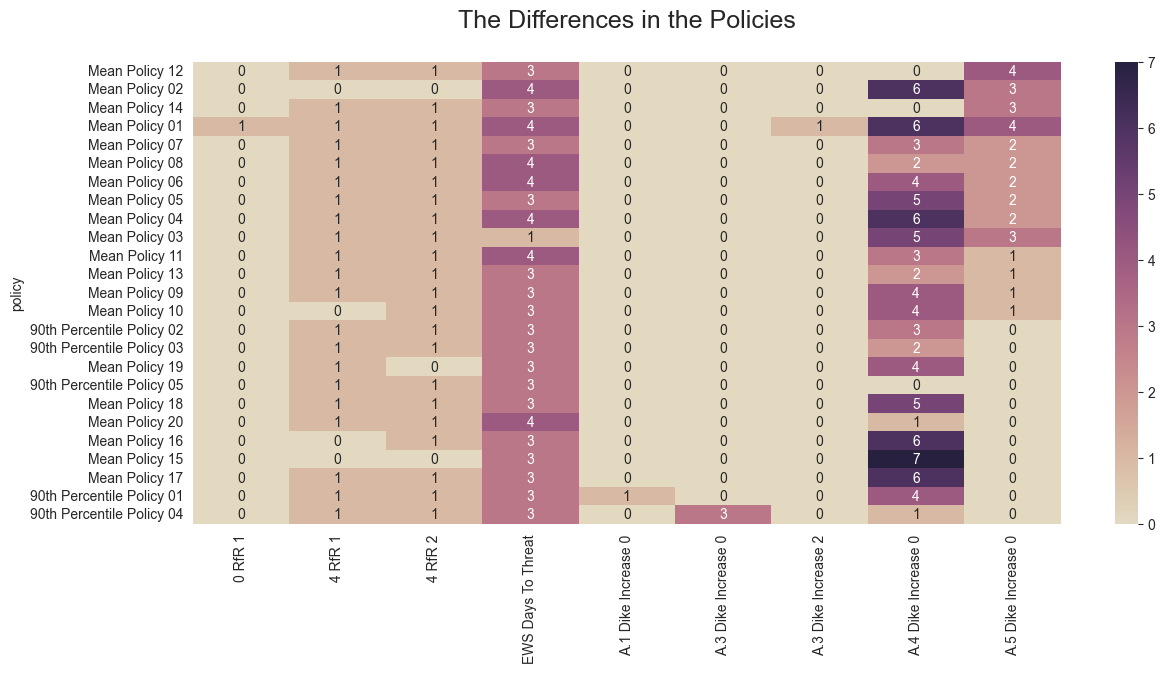

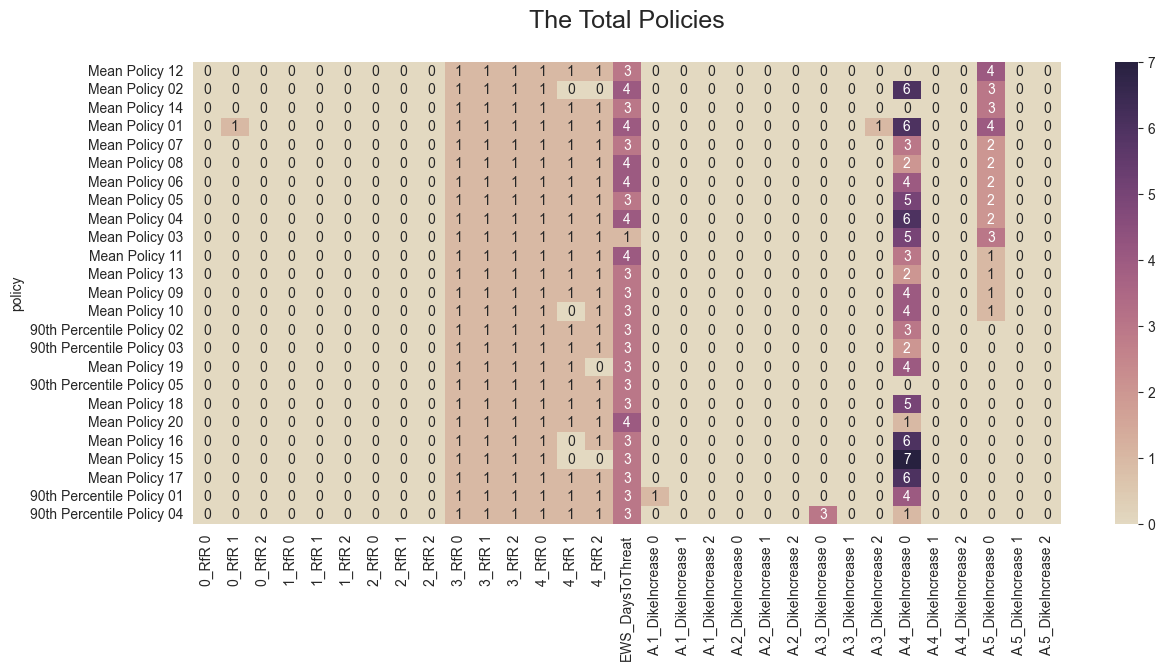

In [14]:
interpretation_policy_ordered = interpretation_policy_preorder.reindex(mean_regret_normalized.index)
total_policy_ordered = total_policy_preorder.reindex(mean_regret_normalized.index)
interpretation_policy_ordered.columns = ['0 RfR 1', '4 RfR 1', '4 RfR 2', 'EWS Days To Threat',
       'A.1 Dike Increase 0', 'A.3 Dike Increase 0', 'A.3 Dike Increase 2',
       'A.4 Dike Increase 0', 'A.5 Dike Increase 0']
plot_regret_heatmap(interpretation_policy_ordered, 'The Differences in the Policies')
plot_regret_heatmap(total_policy_ordered, 'The Total Policies')

# Signal-to-Noise ratio
In the following part, we will calculate the signal to noise ratio of the policies in the 1000 scenarios we ran, we do this in order to indicate how robust and similar the policy responds to different scenarios. Policies with higher SNR are generally more robust because they achieve better mean outcomes while exhibiting lower variability or sensitivity to different scenarios. This is particularly important in decision-making under uncertainty, where robustness indicates resilience against unexpected changes or scenarios. SNR is calculated by multiplying the standard deviation with the mean. In our case all the targets aim to be as low as possible, therefore a low score indicates a high robustness and low uncertainty along with desired values. In the code below, we also normalize these values so that they become more easily comparable among one another.  

In [15]:
def s_to_n(data):
    mean = np.mean(data)
    std = np.std(data)
    if std < 10e-5:
        std = 0
    return mean * std  # Minimize

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    for outcome in ['Combined Expected Annual Damage', 'Combined Dike Investment Costs', 'Combined Expected Number of Deaths']:
        value = outcomes[outcome][logical]
        sn_ratio = s_to_n(value)
        scores[outcome] = sn_ratio
    overall_scores[policy] = scores

scores_df = pd.DataFrame.from_dict(overall_scores).T

normalized_scores = (scores_df - scores_df.min()) / (scores_df.max() - scores_df.min())

In [16]:
print(normalized_scores)

                           Combined Expected Annual Damage  \
90th Percentile Policy 01                         0.802306   
90th Percentile Policy 02                         0.630734   
90th Percentile Policy 03                         0.647953   
90th Percentile Policy 04                         1.000000   
90th Percentile Policy 05                         0.763847   
Mean Policy 01                                    0.000000   
Mean Policy 02                                    0.006973   
Mean Policy 03                                    0.008568   
Mean Policy 04                                    0.057845   
Mean Policy 05                                    0.058506   
Mean Policy 06                                    0.059843   
Mean Policy 07                                    0.065648   
Mean Policy 08                                    0.079240   
Mean Policy 09                                    0.190267   
Mean Policy 10                                    0.192307   
Mean Pol

The code below is intended for plotting and interpretation purposes of the calculated normalized SNR scores from above. On the x axis we will show the Normalized SNR Annual damage of a policy and on the Y-axis the normalized SNR annual deaths will be shown. Furthermore a linear regression is made to show the overall trend and connection between the two variables. The 90th percentile policies will be shown in green and the mean policies in blue. Furthermore, in order to try to make the plot more readable, the size of the points will be relative towards their respective policy number. 

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step3
Plot saved to C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\plots\Step3\SNR_comparison.png


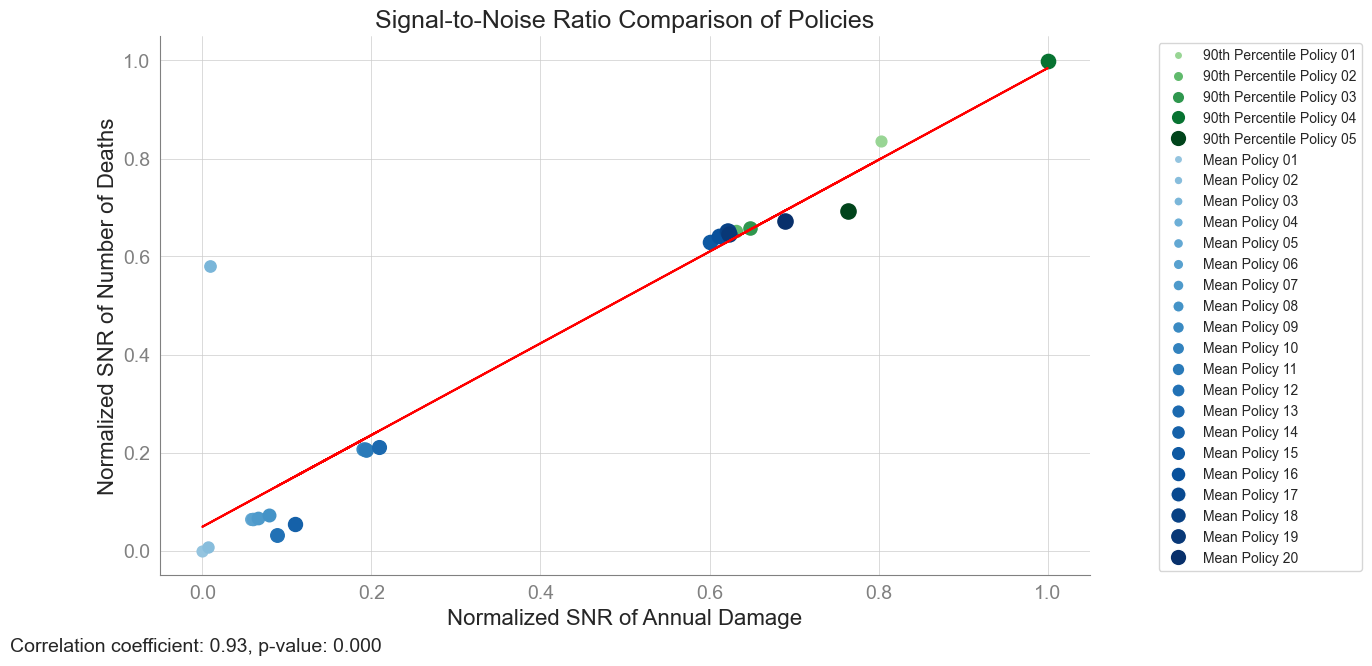

In [17]:
# Function to extract the last two digits from a policy string
def extract_last_two_digits(policy):
    digits = ''.join(filter(str.isdigit, policy))
    return int(digits[-2:])

# Extracting data for the plot
x = normalized_scores['Combined Expected Annual Damage']
y = normalized_scores['Combined Expected Number of Deaths']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Creating the scatter plot
plt.figure(figsize=(12, 7))

green_idx = 0
blue_idx = 0

# Define colors for each type
colors_green = plt.cm.Greens(np.linspace(0.4, 1, len([policy for policy in normalized_scores.index if '90th' in policy])))
colors_blue = plt.cm.Blues(np.linspace(0.4, 1, len([policy for policy in normalized_scores.index if 'Mean' in policy])))

# Define size scaling factors
min_size = 60
max_size = 120

# Calculate the number of steps for each type
num_90th = len([policy for policy in normalized_scores.index if '90th' in policy])
num_mean = len([policy for policy in normalized_scores.index if 'Mean' in policy])

size_step_90th = (max_size - min_size) / max(1, num_90th - 1)
size_step_mean = (max_size - min_size) / max(1, num_mean - 1)

sizes = []

for policy in normalized_scores.index:
    policy_number = extract_last_two_digits(policy)
    if '90th' in policy:
        color = colors_green[green_idx]
        size = min_size + green_idx * size_step_90th
        green_idx += 1
        # plt.text(x[policy], y[policy], str(green_idx), fontsize=7, ha='center', color='white')
        
    else:
        color = colors_blue[blue_idx]
        size = min_size + blue_idx * size_step_mean
        blue_idx += 1
        # plt.text(x[policy], y[policy], str(blue_idx), fontsize=7, ha='center', color='white')
    plt.scatter(x[policy], y[policy], c=[color], s=size)
    sizes.append(size)

# Adding the trend line
plt.plot(x, intercept + slope * x, 'r', label=f'Trend line')

# Adding labels and title with correlation coefficient and p-value
plt.xlabel('Normalized SNR of Annual Damage')
plt.ylabel('Normalized SNR of Number of Deaths')
plt.title('Signal-to-Noise Ratio Comparison of Policies')

# Create legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_green[i], markersize=sizes[i] / 10, label=f'90th Percentile Policy {i+1:02}')
    for i in range(len(colors_green))
] + [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_blue[i], markersize=sizes[len(colors_green) + i] / 10, label=f'Mean Policy {i+1:02}')
    for i in range(len(colors_blue))
]

plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.3, 1))

# Adding a text box below the plot for correlation details
plt.text(0, 0, f'Correlation coefficient: {r_value:.2f}, p-value: {p_value:.3f}', ha='left', fontsize=14, transform=plt.gcf().transFigure)

# Displaying the plot
plt.grid(True)
customize_save_and_show_plot("SNR_comparison", 'Step3')
plt.show()

First of all we see that the trend is upwards, with a very high correlation. Implying that a higher signal to noise ratio in the damage part of the model, leads to a higher signal to noise in the number of deaths part of the model. We clearly see that the 90th percentile policies have a much higher signal to noise ratio than the mean policies. 

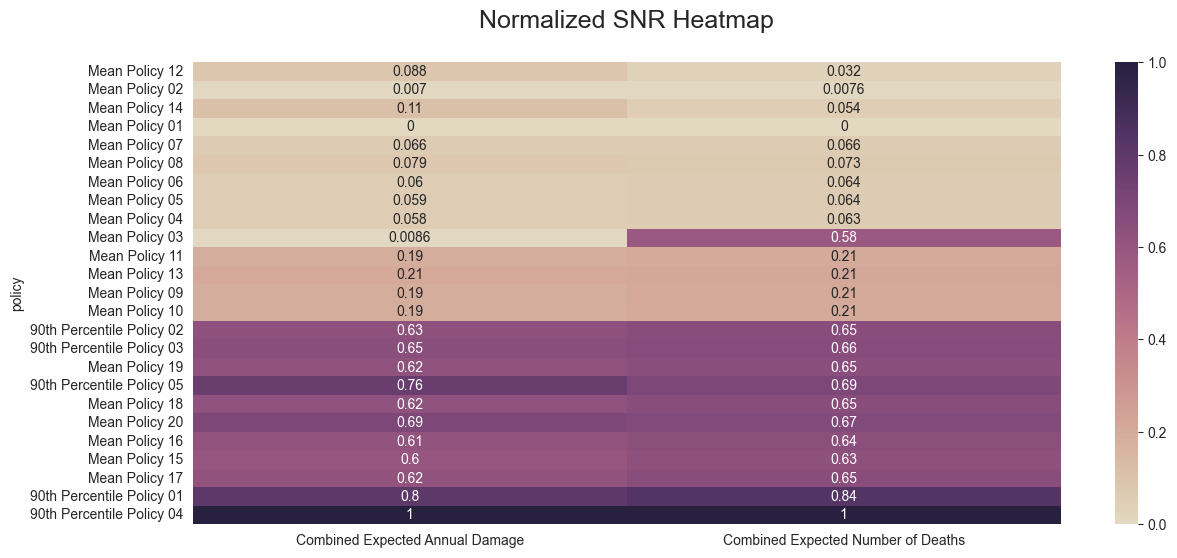

In [18]:
def plot_SNR_heatmap(df, title):
    current_dir = os.getcwd()
    dir_path = os.path.join(current_dir, 'data', 'plots', 'Step3')
    os.makedirs(dir_path, exist_ok=True)

    # Create a heatmap
    plt.figure(figsize=(14, 6))
    sns.heatmap(df, cmap=cmap, annot=True)

    # Adjust the figure to make space for the title and improve layout
    plt.title(title, pad=25, fontsize=18)

    # Save and display the plot
    filename = os.path.join(dir_path, 'Normalized SNR Heatmap.png')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

SNR_dataframe = normalized_scores[['Combined Expected Annual Damage','Combined Expected Number of Deaths']]

SNR_dataframe_aligned = SNR_dataframe.reindex(mean_regret_normalized.index)
plot_SNR_heatmap(SNR_dataframe_aligned,'Normalized SNR Heatmap')

Policies with a low total regret seem to also do reasonably well with the SNR. The 90th percentile policies perform overall worse than the mean policies do. We also see that there are huge differences in the values, as many of the policies score low in the 0 to 0.1 normalized range. Indicating a strong difference in robustness between the policies. Mean policy 03 seems to be an outlier as it has a high signal to noise ratio in the deaths and a low signal to noise ratio in the damages. This deserves further research as to why. Other than that we see four categories of policies, the low between 0 and 0.1, some around 0.20, some around 0.6/7 and only two score higher than 0.8. With 90th percentile policy 04 performing the worst. 